<a href="https://colab.research.google.com/github/alouwyck/vives-deep-learning/blob/main/topic9/Image_Segmentation_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

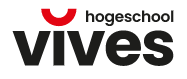<br>


**DEEP LEARNING**<br>
Academiejaar 2022-2023<br>
Andy Louwyck

---



---



# Image Segmentation Challenge

## Opgave

Stel een neuraal netwerk op voor het segmenteren van de "ellipses" dataset. Deze dataset bestaat uit 128 x 128 RGB images met ellipsen en bijhorende masks die voor elke image de ellips aanduidt. De bedoeling is dat het model de ellips op elke image kan onderscheiden van de achtergrond. Er wordt geen rekening gehouden met de contour, d.w.z. dat er slechts 2 klassen moet worden onderscheiden: ellips en achtergrond. Probeer daarna een tweede model op te stellen dat geen neuraal netwerk is, maar toch ook in staat is om de ellipsen van hun achtergrond te onderscheiden. De beide modellen zullen geëvalueerd worden adhv een geheime testset. Wie de hoogste gemiddelde nauwkeurigheid haalt, wint de challenge!

## Dataset

De dataset zit in de zip-file `"ellipses_train_val_only.zip"`. Unzip de file en schrijf de dataset weg naar folder `"ellipses"`:

In [ ]:
import shutil
shutil.unpack_archive("ellipses_train_val_only.zip", "ellipses")

Dit is de folderstructuur van de dataset in Google Colab (met working directory 'content'):

```
content
|_ ellipses
   |_ train
   |_ val
   |_ (test)
```
(Subfolder 'test' ontbreekt bij jullie, maar zal wel aanwezig zijn bij de finale evaluatie na indienen!)

De dataset bestaat uit een training- en validatieset met respectievelijk 5000 en 500 images en bijhorende masks. De testset zit er niet bij en zal opnieuw gebruikt worden als finale evalutie na het indienen van je model. Gebruik onderstaande functie om de images en masks in te lezen en om te zetten naar NumPy arrays:

In [ ]:
import os
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array, array_to_img

def images_from_dir_to_array(nsamples, subset="test", folder="./ellipses"):
    # nsamples is het aantal images in de dataset
    # folder is de hoofddirectory van de dataset
    # subset is de subdirectory van de subdataset
    # retourneert array X met de omgezette images en array y met de omgezette masks

    X, y = [], []

    for id in range(1, nsamples + 1):

        image_file = os.path.join(folder, subset, 'image_' + str(id) + ".jpg")
        mask_file = os.path.join(folder, subset, 'mask_' + str(id) +".png")

        im = img_to_array(load_img(image_file))
        mask = img_to_array(load_img(mask_file, color_mode="grayscale"))

        X.append(im)
        y.append(mask)

    return np.array(X, dtype="float32"), np.array(y, dtype="bool")

In [ ]:
train_X, train_y = images_from_dir_to_array(nsamples=5000, subset="train")
val_X, val_y = images_from_dir_to_array(nsamples=500, subset="val")

print(train_X.shape)
print(train_y.shape)
print(val_X.shape)
print(val_y.shape)

(5000, 128, 128, 3)
(5000, 128, 128, 1)
(500, 128, 128, 3)
(500, 128, 128, 1)


Je ziet dus dat array `X` de originele RGB images bevat van 128 x 128 en array `y` de bijhorende masks die uiteraard ook size 128 x 128 hebben maar slechts 1 kanaal hebben omdat de waarden 0 of 1 zijn.

Vul hier gerust code aan om de dataset te verkennen!

## ConvNet

Als voorbeeld trainen we hier een slecht presterend neuraal netwerk. Het is natuurlijk de bedoeling dat je dit model verbetert!

In [ ]:
from tensorflow import keras
from keras import layers

size = 128

inputs = keras.Input(shape=(size, size, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(1, 3, strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, 3, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(1, 3, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(1, 3, activation="relu", padding="same", strides=2)(x)
outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)

cnn = keras.Model(inputs, outputs)

We compileren het model:

In [ ]:
cnn.compile(optimizer="rmsprop", loss="binary_crossentropy")

We trainen het model en slaan de beste versie op in `"ellips_segmentation.h5"`.

In [ ]:
filename = "ellips_segmentation.h5"

history = cnn.fit(train_X, train_y,
                  epochs=2,
                  batch_size=64,
                  callbacks=[keras.callbacks.ModelCheckpoint(filename, save_best_only=True)],
                  validation_data=(val_X, val_y))

Epoch 1/2
79/79 [==============================] - 39s 484ms/step - loss: 0.6755 - val_loss: 0.6607
Epoch 2/2
79/79 [==============================] - 43s 541ms/step - loss: 0.6469 - val_loss: 0.6334


We moeten nu nog een classifier schrijven die de voorspelde kans van elke pixel omzet naar 0 of 1. We gebruiken hier eenvoudigweg de `round` functie voor:

In [ ]:
def cnn_classifier(X):
    # X is de array met images
    # laadt model "ellips_segmentation.keras" in
    # retourneert de voorspelde masks y_pred
    cnn = keras.models.load_model(filename)  # PAS OP! filename is globale variabele!
    return cnn.predict(X).round()

Ook deze functie kan je verbeteren, door bijvoorbeeld een andere threshold te gebruiken (want de `round` functie gebruikt natuurlijk 0.5 als drempel).

Laten we de functie eens testen:

In [ ]:
y_pred = cnn_classifier(train_X)
print(y_pred.shape)

157/157 [==============================] - 17s 109ms/step
(5000, 128, 128, 1)


## Out-of-the-box Model

Denk nu ook eens 'out-of-the-box' en probeer zelf een model te ontwerpen dat geen gebruik maakt van deep learning om tot hetzelfde of misschien zelfs een beter resultaat te komen!

Je out-of-the-box model implementeer je als functie met de volgende signatuur:

```python
def out_of_the_box_model(X):
    # input zijn de images X
    ...  # hier komt de code
    return y_pred  # de functie retourneert de voorspellingen
```

Als voorbeeld implementeren we een "naïeve" classifier die alles als achtergrond voorspeld. Het resultaat van deze classifier is een baseline en onze modellen moeten dus sowieso beter doen!

In [ ]:
def out_of_the_box_model(X):
    # X is de array met images
    # retourneert array y_pred met voorspelde masks
    return np.zeros(X.shape[:-1], dtype="bool")  # alles achtergrond (= False)

Uiteraard is het de bedoeling dat je hier een beter model uitwerkt!

## Evaluatie

Je deep learning model en je out-of-the-box model zullen geëvalueerd worden adhv de testset die uit 1000 images en bijhorende masks bestaat. De nauwkeurigheid zal berekend voor elke pixel in de dataset. Dat betekent dat het aantal correct geclassificeerde pixels zal gedeeld worden door het totaal aantal pixels, i.e. 128 x 128 x 1000. Dit is functie:

In [ ]:
def get_accuracy(classifier, X, y):
    # classifier is een functie met X als input die de voorspelde masks y_pred retourneert
    # X zijn de images
    # y zijn de masks
    # retourneert de nauwkeurigheid van alle pixels
    y_pred = classifier(X)
    return (y.squeeze() == y_pred.squeeze()).sum() / y.size

Laten we eens de nauwkeurigheid van onze convnet en naïeve classifier berekenen voor de trainingset:

In [ ]:
get_accuracy(cnn_classifier, train_X, train_y)

157/157 [==============================] - 17s 106ms/step


0.883523486328125

In [ ]:
get_accuracy(out_of_the_box_model, train_X, train_y)

0.883523486328125

Ze scoren even goed omdat ze alle twee enkel achtergrond voorspellen, en blijkbaar is 88.35% van de pixels effectief ook achtergrond. Dit toont nogmaals het belang aan van een baseline model!

De nauwkeurigheid voor de validatieset is uiteraard ook twee maal hetzelfde en ligt eveneens rond de 88%:

In [ ]:
get_accuracy(cnn_classifier, val_X, val_y)

16/16 [==============================] - 2s 107ms/step


0.8801942138671875

In [ ]:
get_accuracy(out_of_the_box_model, val_X, val_y)

0.8801942138671875

## Indienen

Klaar? Dien je notebook in op Toledo samen met je opgeslagen neuraal netwerk (als HDF5-file).

Wie de hoogste gemiddelde nauwkeurigheid haalt op beide modellen voor de geheime testset wint de challenge!


Hieronder zie je de code die zal uitgevoerd worden in Google Colab (met het resultaat voor onze twee slechte modellen!):

In [ ]:
test_X, test_y = images_from_dir_to_array(nsamples=1000, subset="test")
acc_cnn = get_accuracy(cnn_classifier, test_X, test_y)
acc_obm = get_accuracy(out_of_the_box_model, test_X, test_y)
print("ConvNet acc:", acc_cnn)
print("Out-of-the-box acc:", acc_obm)
print("Gemiddelde:", (acc_cnn + acc_obm) / 2)

32/32 [==============================] - 4s 117ms/step
ConvNet acc: 0.8779314575195313
Out-of-the-box acc: 0.8779314575195313
Gemiddelde: 0.8779314575195313


**Wie dus de hoogste gemiddelde nauwkeurigheid haalt op de twee modellen, wint de challenge!**

Veel succes!!